In [4]:
import sys
sys.path.append("../") # go to parent dir
#from customFunctions import *

In [99]:
import os
import torch
from torch.nn import functional as F
import cv2
import numpy as np
import torchvision.transforms as transforms
import utils
import model
from attribution_methods_mnist import *
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from evaluaion_methods import *
import gc

In [100]:
print("==============cam_mnist============")

if not os.path.exists('./result'):
    os.mkdir('result/')

is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
net = model.load_net().to(device)
finalconv_name = 'conv'
save_dir = "../datab"
ratio = 0.1

train_loader_mnist = utils.load_data_mnist(batch_size=1,test=False)
test_loader_mnist = utils.load_data_mnist(batch_size=1, test=True)

==============cam_mnist============
LOAD DATA, 60000
LOAD DATA, 10000


In [101]:
train_loader_mnist.dataset.data.shape

torch.Size([60000, 28, 28])

In [102]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    if one_channel:
        plt.imshow(img, cmap="Greys")
    else:
        plt.imshow(img)
        #plt.imshow(np.transpose(img, (1, 2, 0)))

In [103]:
img=train_loader_mnist.dataset.data[0]
img = img.detach().numpy()
img = cv2.applyColorMap(img,cv2.COLORMAP_JET)
print(img.shape)

(28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


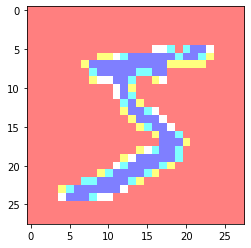

In [104]:
matplotlib_imshow(img)

In [243]:
net = model.load__MnistCNN().to(device)
features_blobs = []
finalconv_name = 'conv'
final_conv = 'conv'
net.eval()
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
device = device
datapath = "./datab/file_mnist2.hdf5"
i = 0
dset = ""

In [244]:
net

CNN_mnist(
  (conv): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(28, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [248]:
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
net._modules.get(final_conv).register_forward_hook(hook_feature)

In [246]:
def hook_feature(module, input, output):
    features_blobs.append(output.cpu().data.numpy())
net._modules.get(finalconv_name).register_forward_hook(hook_feature)
features_blobs

[]

In [254]:
def get_cam(net, features_blobs, img_pil, root_img):
    print('get_cam')
    params = list(net.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0)).cuda()
    logit = net(img_variable)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)

    # output: the prediction
    #for i in range(0, 2):
    #    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    #    print(line)

    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

    # render the CAM and output
    #print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
    img = cv2.imread(root_img)
    height, width, _ = img.shape
    CAM = cv2.resize(CAMs[0], (width, height))
    heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    cv2.imwrite('cam.jpg', result)

In [258]:
for idx ,(img,target) in enumerate(train_loader_mnist):
    root='./result/cam0.jpg'
    transToPil = transforms.ToPILImage()
    transToTensor = transforms.ToTensor()
    #img = transToPil(torchvision.utils.make_grid(img))
    get_cam(net,feature_blobs,img,root)
    #cv2.imwrite('./result/cam{}.jpg'.format(idx), heatmap_b)
    if idx ==1: break

get_cam


RuntimeError: Given groups=1, weight of size 28 1 3 3, expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

# Test

In [227]:
 def returnCAM(feature_conv, weight_softmax, class_idx):
        size_upsample = (28, 28)
        bz, nc, h, w = feature_conv.shape
        output_cam = []
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h * w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
        #del cam_img,cam
        #gc.collect()

        #return output_cam
        return cv2.resize(cam_img, size_upsample)

In [228]:
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

IndexError: list index out of range

In [213]:
def generate_image(img, i):
    global feature_blobs
    print(img.shape)
    print("=================generate image=============================")
    img = Variable(img, requires_grad=True)

    net._modules.get(finalconv_name).register_forward_hook(hook_feature)

    img_tensor = img.to(device)
    logit, _ = net(img_tensor)
    h_x = F.softmax(logit, dim=1).data.squeeze()

    weight_softmaxtemp = weight_softmax
    feature_blobstemp = feature_blobs[0]
    probs, idx = h_x.sort(0, True)
    idx_temp = [idx[0]]
    output_cam = returnCAM(feature_blobs[0], weight_softmax, [idx[0].item()])
    height, width = 28, 28
    heatmap = cv2.applyColorMap(cv2.resize(output_cam[0], (width, height)), cv2.COLORMAP_JET)
    #heatmap2 = cv2.resize(output_cam[0], (width, height))

    img = img.detach().numpy()
    img2 = img[0]
    img2 = np.transpose(img2, axes=(1, 2, 0))
    img2 = cv2.resize(img2, (28, 28))
    img2 = cv2.applyColorMap(cv2.resize(output_cam[0], (width, height)), cv2.COLORMAP_JET)

    camsresult = np.array(list(map(resize_image, heatmap, img2)))
    result = heatmap* 0.3 + img2 * 0.7

    
    feature_blobs = []
    del img_tensor, output_cam, img2, img
    gc.collect()
    # result=zip(camsresult,heatmap,probs.detach().cpu().numpy(), idx.detach().cpu().numpy())

    return camsresult,heatmap, probs.detach().cpu().numpy(), idx.detach().cpu().numpy(), result

In [214]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg),(1,2,0))
    plt.show()

In [215]:
for idx ,(img,target) in enumerate(train_loader_mnist):
    sal_maps_b, heatmap_b,probs_b, preds_b,result=generate_image(img,idx)
    cv2.imwrite('./result/cam{}.jpg'.format(idx), heatmap_b)
    if idx ==1: break

torch.Size([1, 1, 128, 128])
=================generate image=============================
torch.Size([1, 1, 128, 128])
=================generate image=============================


In [125]:
train_loader_mnist.dataset[1][0].shape

torch.Size([1, 128, 128])

In [138]:
#img=train_loader_mnist.dataset[1][0]
#img.resize((1,) + img.shape)
#print(img.shape)

In [139]:
#sal_maps_b, probs_b, preds_b = generate_image(img, 0)

LOAD DATA, 60000
LOAD DATA, 10000
torch.Size([1, 1, 128, 128])
torch.Size([3, 128, 128])


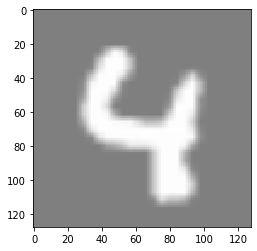

In [182]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import string
import math

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


train_loader_mnist = utils.load_data_mnist(batch_size=1,test=False)
test_loader_mnist = utils.load_data_mnist(batch_size=1, test=True)

dataiter = iter(train_loader_mnist)
images = dataiter.next()
print(images[0].shape)
print(torchvision.utils.make_grid(images[0]).shape)

# show images
# print(images[0])
imshow(torchvision.utils.make_grid(images[0]))